In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
from torchvision import datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.utils import save_image

import os
import numpy as np
import matplotlib.pyplot as plt

C:\Users\user\.conda\envs\torch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\user\.conda\envs\torch\lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device = {device}")
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

device = cuda


In [3]:
batch_size = 100

In [18]:
# Image Processing
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], # 1 for gray scale 만약, RGB channels라면 mean=(0.5, 0.5, 0.5)
                                         std=[0.5])])  # 1 for gray scale 만약, RGB channels라면 std=(0.5, 0.5, 0.5)

# MNIST 데이터셋
mnist_train = dsets.MNIST(root='data/',
                         train=True, # 트레인 셋
                         transform=transform,
                         download=True)
mnist_test  = dsets.MNIST(root='data/', 
                          train=False,
                          transform=transform,
                          download=True)
# 랜덤으로 9개만 시각화

In [19]:
# 14*14 -> Y
train_yy = dsets.MNIST(root='data/',
                         train=True, 
                         transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], # 1 for gray scale 만약, RGB channels라면 mean=(0.5, 0.5, 0.5)
                                                         std=[0.5]),
                                    transforms.FiveCrop(size=(14,14))]) ,
                         download=False)

train_Y = torch.zeros([60000,1,14,14])
for i in range(len(mnist_train)):
    temp = train_yy[i][0][3]
    train_Y[i] = temp
    if i % 6000 == 0:
        print("train_Y: ",((i)/6000)*10,"% done")

print("-"*20)
# 28*28 -> X
train_X = torch.zeros([60000,1,28,28])

for i in range(len(mnist_train)):
    temp = mnist_train[i][0]
    temp[:,14:,14:] = 0
    train_X[i] = temp
    if i % 6000 == 0:
        print("train_X: ",((i)/6000)*10,"% done")

train_Y:  0.0 % done
train_Y:  10.0 % done
train_Y:  20.0 % done
train_Y:  30.0 % done
train_Y:  40.0 % done
train_Y:  50.0 % done
train_Y:  60.0 % done
train_Y:  70.0 % done
train_Y:  80.0 % done
train_Y:  90.0 % done
--------------------
train_X:  0.0 % done
train_X:  10.0 % done
train_X:  20.0 % done
train_X:  30.0 % done
train_X:  40.0 % done
train_X:  50.0 % done
train_X:  60.0 % done
train_X:  70.0 % done
train_X:  80.0 % done
train_X:  90.0 % done


In [20]:
print(train_X.min())
print(train_X.max())
print(train_Y.min())
print(train_Y.max())

tensor(-1.)
tensor(1.)
tensor(-1.)
tensor(1.)


In [21]:
class CustomImageDataset(Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X
        Y = self.Y
        return X[idx], Y[idx]

In [22]:
trainset = CustomImageDataset(train_X,train_Y)

In [24]:
def imshow(img):
    img = (img+1) / 2
    img = img.squeeze() # 차원 중 사이즈 1 을 제거
    np_img = img.numpy() # 이미지 픽셀을 넘파이 배열로 변환
    plt.imshow(np_img,cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach()) # 이미지 그리드 생성, 이미지 출력만을 위해 cpu에 담고 추적 방이
    img = (img+1)/2
    npimg = img.numpy() # 이미지 픽셀을 넘파이 배열로 변환
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

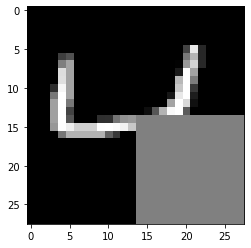

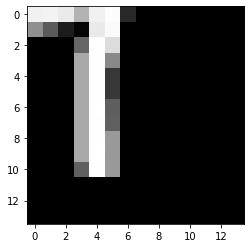

In [25]:
imshow(trainset.__getitem__(2)[0]) # X
imshow(trainset.__getitem__(2)[1]) # Y


In [26]:
# data loader
data_loader = torch.utils.data.DataLoader(dataset=trainset, 
                                          batch_size=batch_size,
                                          shuffle=True) 

torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 14, 14])


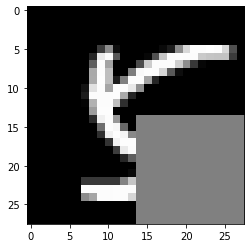

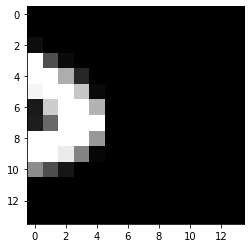

In [27]:
# check the data_loader 

for X,Y in data_loader:
    print(X.size())
    print(Y.size())
    imshow(X[1])
    imshow(Y[1])
    break

In [28]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.D1 = nn.Sequential(
            nn.Conv2d(1,64,5,2,padding=1), # [100, 64, 13, 13]
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,4,1,padding=1), # [100, 128, 12, 12]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(1) # [100, 18432]
            )
        self.D2 = nn.Sequential(
            nn.Conv2d(1,32,5,2,padding=1), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32,64,5,2,padding=1), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Flatten(1) # [100, 256]
            )
        self.D3 = nn.Sequential(
            nn.Linear(18688,128), 
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64,1) # [100, 1]
            )
    def forward(self,X,Y):
        disc_X = self.D1(X)
        disc_Y = self.D2(Y)
        Dout1 = torch.concat((disc_X,disc_Y),1)
        Dout2 = self.D3(Dout1)
        
        return Dout2

In [29]:
D = Discriminator()
print(D)

Discriminator(
  (D1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (D2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (D3): Sequential(
    (0): Linear(in_fe

In [30]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.G1 = nn.Sequential(
            nn.Flatten(1), # 
            nn.Linear(784, 128), # 100*128
            nn.BatchNorm1d(128), # 100*128
            nn.LeakyReLU(0.2)) # 100*128

        self.G2 = nn.Sequential(
            nn.ConvTranspose2d(228,256,kernel_size=(7,7),stride=(1,1),padding=0), # [100, 256, 7, 7]
            nn.BatchNorm2d(256), # 
            nn.LeakyReLU(0.2), # [100, 256, 7, 7]
            nn.ConvTranspose2d(256,128,kernel_size=(5,5),stride=(2,2),padding=2,output_padding =1), # [100, 128, 14, 14]
            nn.BatchNorm2d(128), # 
            nn.LeakyReLU(0.2),#
            nn.ConvTranspose2d(128,1,kernel_size=(5,5),stride=(1,1),padding=2), # [100, 1, 14, 14] -> should be matched with size of y.
            nn.Tanh()# [100, 1, 14, 14]
            )

    def forward(self,X,eta_dist="Normal",eta_dim=100,device=device):
        # random error part
        if eta_dist == "Normal":
            eta = torch.randn(X.size()[0], eta_dim, device=device) # X.size()[0] :batch_size

        elif eta_dist == "Unif":
            eta = torch.rand(X.size()[0], eta_dim, device=device)

        else :
            raise Exception("Please specify the correct distribution. Normal or Unif")

        # construcnt the full model
        Gout1 = self.G1(X)
        Gout2 = torch.concat((Gout1,eta),1).resize(X.size()[0],(128 + eta_dim),1,1)
        Gout3 = self.G2(Gout2)
    
        return Gout3

In [31]:
G = Generator()
print(G)

Generator(
  (G1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (G2): Sequential(
    (0): ConvTranspose2d(228, 256, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(128, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): Tanh()
  )
)


In [35]:
# loss function 직접 구현하기

In [36]:
# Defince the fenchel conjugacy loss 

# def disc_loss(output,label): # label : 1 for real, -1 for fake
#     loss = - torch.mean( output * (label - 1.) * (-1.0/2.0) - torch.exp(output) * (label + 1.) * (1.0/2.0) )
#     return loss

def disc_loss(output,label): # label : 1 for real, -1 for fake
    loss = - torch.mean( output * (label + 1.) * (1.0/2.0) - torch.exp(output) * (label - 1.) * (-1.0/2.0) )
    return loss

def gen_loss(output,label): # all labels are -1.(all fake data)
    loss = torch.mean(output)
    return loss

In [43]:
num_epochs = 2500

In [44]:
# making plots 


def imshow_sub(img,ax,idx):
    img = (img+1) / 2
    img = img.squeeze() # 차원 중 사이즈 1 을 제거
    np_img = img.numpy() # 이미지 픽셀을 넘파이 배열로 변환
    ax[idx].imshow(np_img,cmap='gray')
    
def making_plots(data=train_X,device=device,sample_idx = [1,2,3,4,5,6,7,8,9,10]):
    sample_batch = train_X[sample_idx].clone()
    sample_batch = (sample_batch*0.5 + 0.5)*255
    res_y_tilde = G(sample_batch.to(device))
    res_y_tilde = (res_y_tilde*0.5 + 0.5)*255
    sample_batch[:,:,14:,14:] = res_y_tilde # reconstructed image
    fig, ax = plt.subplots(1,10, figsize=(15,8))

    for i in range(len(sample_idx)):
        imshow_sub(sample_batch[i].detach(),ax,i)
        ax[i].axis('off')
    plt.show()

In [ ]:
# training

real_scores = []
fake_scores = []
gloss_lst = []
dloss_lst = [] 

total_step = len(data_loader)
D = Discriminator().to(device)
G = Generator().to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.00001)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

for epoch in range(num_epochs):
    for i, (X,Y) in enumerate(data_loader):
        X = X.to(device)
        Y = Y.to(device)
        
        # Create the labels which are later used as input for loss function
        real_labels = -torch.ones(batch_size, 1).to(device)
        fake_labels = torch.ones(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute Loss using real images where custom_loss(x, y)
        
        Dout = D(X,Y)
        d_loss_real = disc_loss(Dout,real_labels)
        real_score = Dout
        
        # Compute Loss using fake images
        
        Gout = G(X,eta_dist="Normal",eta_dim=100)
        DGout = D(X,Gout)
        d_loss_fake = disc_loss(DGout, fake_labels)
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #
    
        # Compute loss with fake images
        DGout2 = D(X,G(X,eta_dist="Normal",eta_dim=100))
        fake_score = DGout2

        # Backprop and optimize
        g_loss = gen_loss(DGout2, -1)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        
        if (i+1) % 600 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
            making_plots(data=train_X,device=device,sample_idx = [1,2,3,4,5,6,7,8,9,10])
            
    real_scores.append(real_score.mean().item())            
    fake_scores.append(fake_score.mean().item())
    gloss_lst.append(g_loss.item())
    dloss_lst.append(d_loss.item())
    
    
#     # real image 저장
#     if (epoch+1) == 1:
#         images = images.reshape(images.size(0), 1, 28, 28)
#         save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
#     # 생성된 이미지 저장
#     fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
#     save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# 생성자, 판별자 각각 모델 저장
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

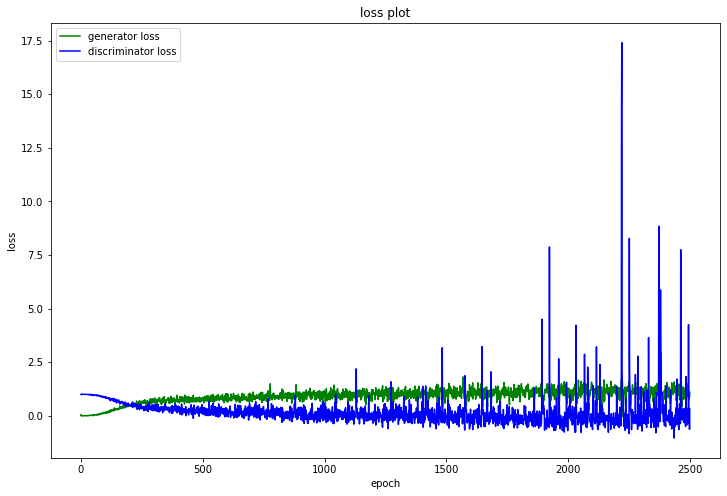

In [47]:
# plot    
plt.figure(figsize = (12, 8))
plt.xlabel('epoch')
plt.ylabel('loss')
x = np.arange(num_epochs)  # num_epochs
plt.plot(x, gloss_lst, 'g', label='generator loss')
plt.plot(x, dloss_lst, 'b', label='discriminator loss')
plt.title("loss plot")
plt.legend()
plt.show()

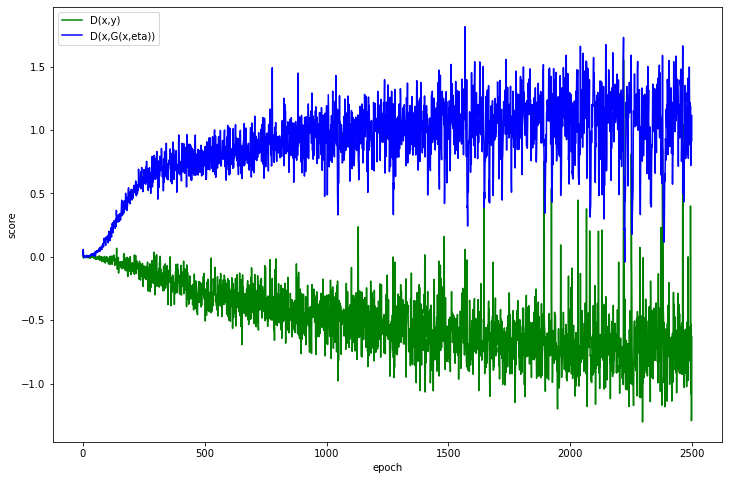

In [53]:
# plot    
plt.figure(figsize = (12, 8))
plt.xlabel('epoch')
plt.ylabel('score')
x = np.arange(num_epochs)
plt.plot(x, real_scores, 'g', label='D(x,y)')
plt.plot(x, fake_scores, 'b', label='D(x,G(x,eta))')
plt.legend()
plt.show()